# From AE to CVAE : basics and codes

This is part of my learning process of generative models. This notebook contains the vanilla models of AE, VAE and CVAE. The trainings and validations were done using MNIST dataset for symplicity and speed.
The models were constructed using pytorch from scratch. The data were treated as images (using convolutional layers) not array of values (linear layers) for adaptibility for other models and datasets (3 chennels images).

The objectif is to learn to construct, to train and to use the model, but not to optimize training or inference process. So the parameters optimization, validation and test parts were omitted.
All training and inferences were run on CPU. It takes maximal no more than several minutes per epoch.

In [1]:
# modules
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import matplotlib.pyplot as plt
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as utils

## Data preparation
### use MNIST dataset 

In [2]:
## application for denoising mnist dataset

transform = [
    transforms.ToTensor(), # convert data to pytorch tensor, this op scales alos the data to [0, 1]
]

transform = transforms.Compose(transform)

data = datasets.MNIST("./mnist", download=False, transform=transform)

In [3]:
batch_size = 200
train_loader = utils.DataLoader(data, batch_size)
valid_loader = utils.DataLoader(data, batch_size)


print(sum([1 for _ in train_loader]), sum([1 for _ in valid_loader]))
print(type(next(iter(train_loader))[0]))

300 300
<class 'torch.Tensor'>


## Autoencoder

The Autoencoder model consists of an encoder and a decoder. The encoder module transform the original data (eg. image) to a lower dimensional representation called lattent space, while the decoder tries to reconstruct the latents space to the original data. If the output of the decoder is identical to the original data, the latent space can be considered a perfect presentation of the original data.
The AE can be used to compress the original data, to denoise data, and to do quality enhancement, etc.

In [4]:
# AE model
# Encoder of 4 convolutional layer and decode of 4 upsampling layer
# the latent space is of dimension 2 by default

class AutoEncoderDecoder (nn.Module):

    def __init__(self, enc_filters=[1,16,32,48,64], dec_filters=[64,48,32,16,1], lin_dim=2):
        
        super().__init__()
        self.enc_filters = enc_filters
        self.dec_filters = dec_filters
        self.lin_dim = lin_dim
        
        self.enc_convs = nn.Sequential()
        
        for i in range(len(enc_filters)-1):
            
            self.enc_convs.add_module(f"LayerE_conv_{i}", nn.Conv2d(enc_filters[i], enc_filters[i+1], kernel_size=3, padding=1))
            self.enc_convs.add_module(f"LayerE_rlu_{i}", nn.LeakyReLU(0.1))
            self.enc_convs.add_module(f"LayerE_pool_{i}", nn.MaxPool2d(3, stride=2, padding=1))

        self.linear1 = nn.Linear(4*64, lin_dim)
        
        self.linear2 = nn.Linear(lin_dim, 4*64)
        
        self.dec_convs = nn.Sequential()
        
        for i in range(len(dec_filters)-1):
            
            self.dec_convs.add_module(f"LayerD_conv_{i}", nn.ConvTranspose2d(dec_filters[i], dec_filters[i+1], kernel_size=2, stride=2))
            
            self.dec_convs.add_module(f"LayerD_relu_{i}", nn.LeakyReLU(0.1))

        self.sigmoid = nn.Sigmoid()

        self.enc = 0

    @staticmethod
    def crop(x, size=28):
        
        trans = transforms.CenterCrop(size)
        
        return trans(x)

    def forward(self, x):
        
        # x size (batch, 1, 28, 28)
        out = self.enc_convs(x)
        out = out.view(-1, 64*4)
        out = self.linear1(out)
        self.enc = out
        out = self.linear2(out)
        out = out.view(-1, 64, 2, 2)
        out = self.dec_convs(out)
        
        return self.sigmoid(self.crop(out))

# show model structure
torchsummary.summary(AutoEncoderDecoder(), input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         LeakyReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
         LeakyReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 48, 7, 7]          13,872
         LeakyReLU-8             [-1, 48, 7, 7]               0
         MaxPool2d-9             [-1, 48, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          27,712
        LeakyReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Linear-13                    [-1, 2]             514
           Linear-14                  [

torch.Size([200, 1, 28, 28])


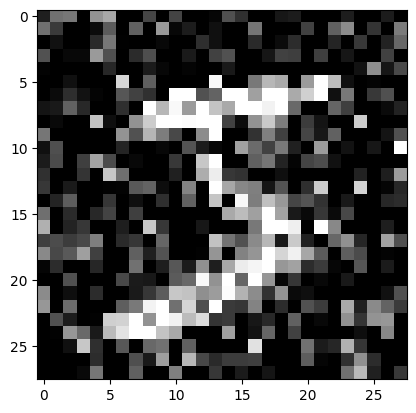

In [5]:
# Here we use AE to do the image denoising

## function to add gaussian noises
def addNoise(batch, noise_level=0.5):
    strength = torch.rand(1) * noise_level # generate noise factor
    noise = torch.randn(batch.size()) * strength
    return torch.clamp(batch + noise, 0, 1) # clamp the values

## test
a = next(iter(train_loader))[0]
b = addNoise(a)
print(b.size())
plt.imshow(b[0].squeeze(0).squeeze(1), cmap="gray")

In [6]:
## train AE model

ae = AutoEncoderDecoder(lin_dim=32)

epochs = 10
lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr)

for e in range(epochs):
    loss_tot = 0
    loss_num = 0

    for batch, _ in train_loader:
        # prediction
        input = addNoise(batch)
        pred = ae(input)
        #print(pred.size(), batch.size())
        # register loss
        loss = loss_fn(pred, batch)
        loss_num += len(batch)
        loss_tot += loss * loss_num
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("epoch {}/{}: train loss: {}".format(e+1, epochs, loss_tot/loss_num))   

epoch 1/10: train loss: 10.454254150390625
epoch 2/10: train loss: 9.350725173950195
epoch 3/10: train loss: 7.741603851318359
epoch 4/10: train loss: 6.163487911224365
epoch 5/10: train loss: 5.207060813903809
epoch 6/10: train loss: 4.520320892333984
epoch 7/10: train loss: 4.027547836303711
epoch 8/10: train loss: 3.6241934299468994
epoch 9/10: train loss: 3.333268404006958
epoch 10/10: train loss: 3.096402168273926


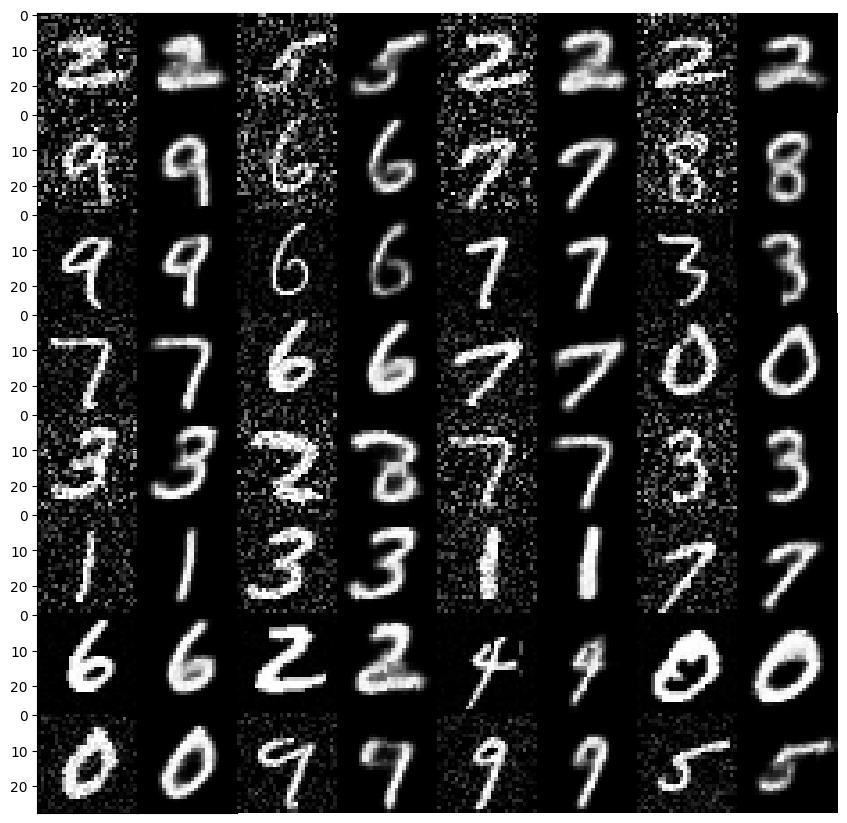

In [9]:
def valid_test(img):
    input = addNoise(img)
    with torch.no_grad(): pred = ae(input)
    torch.clamp(pred, 0, 1)
    return pred, input

## test
nCol = 8
nRow = 8
fig, ax = plt.subplots(nRow, nCol, gridspec_kw=dict(wspace=0.0, hspace=0.0, \
                     top=1. - 0.5 / (nRow + 1), bottom=0.5 / (nRow + 1), \
                     left=0.5 / (nCol + 1), right=1 - 0.5 / (nCol + 1)), \
                    figsize=(nCol + 1, nRow + 1),
                    sharey='row', sharex='col', #  optionally
                      )
for i in range(nCol):
    a = next(iter(valid_loader))[0]
    pred, orig = valid_test(a)
    ind = torch.randint(0, 200, (4,))
    ax[i, 0].imshow(orig[ind[0]][0], cmap="gray") # noised image
    ax[i, 1].imshow(pred[ind[0]][0], cmap="gray") # denoised image
    
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)

    ax[i, 2].imshow(orig[ind[1]][0], cmap="gray") # noised image
    ax[i, 3].imshow(pred[ind[1]][0], cmap="gray") # denoised image
    
    ax[i, 2].set_axis_off()
    ax[i, 3].set_axis_off()

    ax[i, 4].imshow(orig[ind[2]][0], cmap="gray") # noised image
    ax[i, 5].imshow(pred[ind[2]][0], cmap="gray") # denoised image
    
    ax[i, 4].set_axis_off()
    ax[i, 5].set_axis_off()

    ax[i, 6].imshow(orig[ind[3]][0], cmap="gray") # noised image
    ax[i, 7].imshow(pred[ind[3]][0], cmap="gray") # denoised image
    
    ax[i, 6].set_axis_off()
    ax[i, 7].set_axis_off()


## VAE (Variational Autoencoder)

For AE model, we don't have knowledge on the latent space. On the other hand, the VAE, we hypothesis that the lattent attributes follows the normal distribution: $z -> p(z) \propto N(\mu, \sigma)$.
VAE can be used to generate data by simpling the latent space values.

 * input: tensor x -> p(z | x)
 * latent space : tensor z -> p(z)
 * output: tensor y -> p(y | z)
 * loss function: l = ||x-$\hat{x}$||$^2$ + KL[$N(\mu_x, \sigma_x), N(0,1)$]

The loss consists of 2 parts: the data difference and the similarity of the distribution of the latent space and the hypothesised distribution (normal in this case). The measure of the distribution similarity is calculated using KL divergence.

In [5]:
class Encoder(nn.Module):

    def __init__(self, enc_filters=[1,16,32,48,64], latent_dim=2) -> None:
        super().__init__()
        self.enc_filters = enc_filters
        self.latent_dim = latent_dim
        
        self.enc_convs = nn.Sequential()
        for i in range(len(enc_filters)-1):
            self.enc_convs.add_module(f"LayerE_conv_{i}", nn.Conv2d(enc_filters[i], enc_filters[i+1], kernel_size=3, padding=1))
            self.enc_convs.add_module(f"LayerE_rlu_{i}", nn.LeakyReLU(0.1))
            self.enc_convs.add_module(f"LayerE_pool_{i}", nn.MaxPool2d(3, stride=2, padding=1))

        self.linear1 = nn.Linear(4*64, latent_dim*2)
        self.normal = torch.distributions.Normal(0, 1) # standard normal
        self.mu = 0
        self.sigma = 0

    def sample(self, mu, sigma):
        # reparameterization trick - sampling, univariate normal
        out = mu + sigma * self.normal.rsample(mu.size())
        return out

    def forward(self, x):

        out_enc = self.enc_convs(x)

        out_enc = out_enc.view(out_enc.size()[0], -1)
        latent = self.linear1(out_enc)

        self.mu, self.sigma = latent.chunk(2, dim=-1)
        self.sigma = torch.exp(self.sigma)

        z = self.sample(self.mu, self.sigma)

        return z


class Decoder(nn.Module):

    def __init__(self, dec_filters=[64,48,32,16,1], latent_dim=2) -> None:
        
        super().__init__()
        
        self.dec_filters = dec_filters
        self.latent_dim = latent_dim
        self.linear = nn.Linear(latent_dim, 64*2*2)
        
        self.dec_convs = nn.Sequential()
        for i in range(len(dec_filters)-1):
            self.dec_convs.add_module(f"LayerD_conv_{i}", nn.ConvTranspose2d(dec_filters[i], dec_filters[i+1], kernel_size=2, stride=2))
            #self.dec_convs.add_module(f"LayerD_conv_{i}", nn.Upsample(scale_factor=2, mode='nearest'))
            self.dec_convs.add_module(f"LayerD_relu_{i}", nn.LeakyReLU(0.1))

        self.sigmoid = nn.Sigmoid()

    @staticmethod
    def crop(x, size=28):
        trans = transforms.CenterCrop(size)
        return trans(x)

    def forward(self, x):

        out_dec = self.linear(x)
        out_dec = out_dec.view(-1, 64, 2, 2)
        # input size (batch, 64, 2, 2)
        out_dec = self.dec_convs(out_dec)
        
        return self.sigmoid(self.crop(out_dec))
        
        
class Vae(nn.Module):

    def __init__(self, enc_filters=[1,16,32,48,64], dec_filters=[64,48,32,16,1], latent_dim=10) -> None:
        super().__init__()
        self.encoder = Encoder(enc_filters, latent_dim)
        self.decoder = Decoder(dec_filters,latent_dim)
        self.dec_size = dec_filters[0]


    def forward(self, x) -> torch.Tensor:
        x = self.encoder(x)
        
        #out_dec = out_dec.view((x.size()[0], self.dec_size, 2, 2))

        out_dec = self.decoder(x)
        
        return out_dec

vae = Vae(latent_dim=32)
torchsummary.summary(vae, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         LeakyReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
         LeakyReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 48, 7, 7]          13,872
         LeakyReLU-8             [-1, 48, 7, 7]               0
         MaxPool2d-9             [-1, 48, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          27,712
        LeakyReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Linear-13                   [-1, 64]          16,448
          Encoder-14                   

In [9]:
def loss_func(xhat, x, mu, sigma, ratio=0.5):
    
    l1 = torch.sum((x - xhat)**2)
    l2 = torch.sum((sigma**2 + mu**2 - torch.log(sigma) - 0.5))
    #print(xhat.size(), x.size())
    #l1 = nn.functional.cross_entropy(xhat, x, reduction='sum')
    #l2 = -0.5 * torch.sum(1 + torch.log(sigma) - mu.pow(2) - sigma)
    #print(l1, l2)
    return l1, l2

In [73]:
# training

vae = Vae(latent_dim=32)

epochs = 10
lr = 0.01

loss_fn = loss_func
optimizer = optim.Adam(vae.parameters(), lr=lr)

for e in range(epochs):
    loss_tot = 0
    l1_tot = 0
    l2_tot = 0
    loss_num = 0
    for batch,_ in train_loader:

        pred = vae(batch)
        l1, l2 = loss_func(pred, batch, vae.encoder.mu, vae.encoder.sigma)
        
        loss = l1 + l2
        
        loss_num += len(batch)
        loss_tot += loss
        l1_tot += l1
        l2_tot += l2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("epoch {}/{}: total loss: {}, reconstruction loss: {}, KL loss: {}".format(e+1, epochs, loss_tot/loss_num, l1_tot/loss_num, l2_tot/loss_num))
         

epoch 1/10: total loss: 43.201175689697266, reconstruction loss: 22.242734909057617, KL loss: 20.95840835571289
epoch 2/10: total loss: 42.4023323059082, reconstruction loss: 21.233701705932617, KL loss: 21.16864013671875
epoch 3/10: total loss: 42.34600067138672, reconstruction loss: 21.149211883544922, KL loss: 21.196773529052734
epoch 4/10: total loss: 42.2348747253418, reconstruction loss: 20.959962844848633, KL loss: 21.27490234375
epoch 5/10: total loss: 42.15607833862305, reconstruction loss: 20.855213165283203, KL loss: 21.300874710083008
epoch 6/10: total loss: 41.98361587524414, reconstruction loss: 20.575881958007812, KL loss: 21.407699584960938
epoch 7/10: total loss: 41.927490234375, reconstruction loss: 20.445058822631836, KL loss: 21.48241424560547
epoch 8/10: total loss: 41.86075973510742, reconstruction loss: 20.323110580444336, KL loss: 21.53763198852539
epoch 9/10: total loss: 41.8137321472168, reconstruction loss: 20.270462036132812, KL loss: 21.543310165405273
epoc

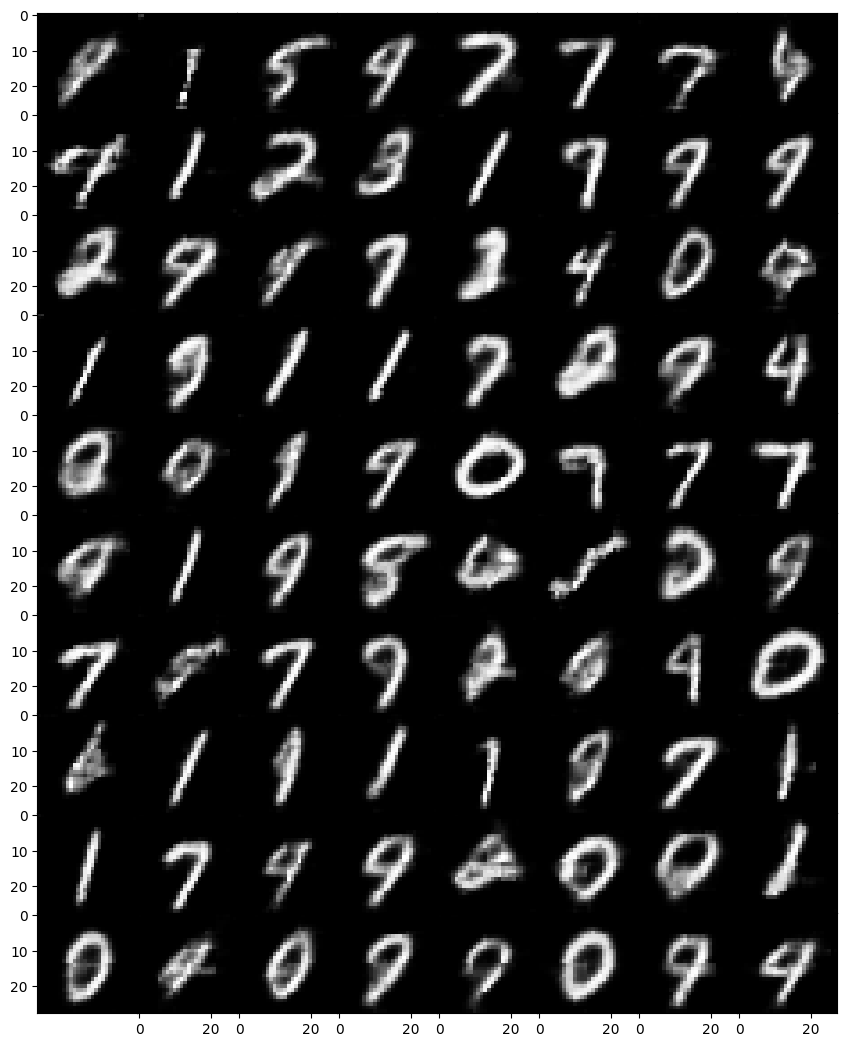

In [64]:
# valid function

def valid_test():
    mu = torch.rand((1,32))
    sigma = torch.rand((1,32))
    z = vae.encoder.sample(mu, sigma)
    #print(z.size())
    with torch.no_grad(): out = vae.decoder(z)
    return out[0][0]
    #plt.imshow(out[0][0], cmap="gray")


nCol = 8
nRow = 10
fig, ax = plt.subplots(nRow, nCol, gridspec_kw=dict(wspace=0.0, hspace=0.0, \
                     top=1. - 0.5 / (nRow + 1), bottom=0.5 / (nRow + 1), \
                     left=0.5 / (nCol + 1), right=1 - 0.5 / (nCol + 1)), \
                    figsize=(nCol + 1, nRow + 1),
                    sharey='row', sharex='col', #  optionally
                      )
for i in range(nRow):
    for j in range(nCol):
        im = valid_test()
        ax[i, j].imshow(im, cmap="gray")
        ax[i, 0].get_xaxis().set_visible(False)

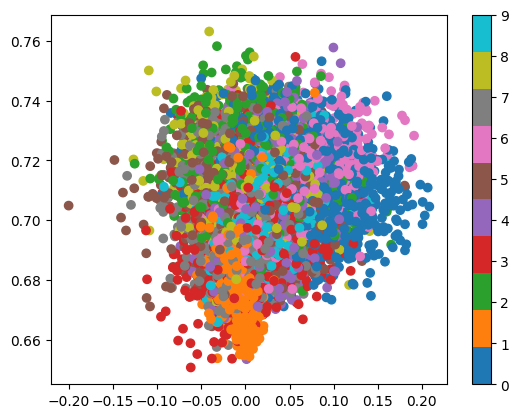

In [91]:
# plot the latent space.

def plot_latent(model, data, latent=0, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = vae.encoder(x)
        #print(vae.encoder.sigma.detach().numpy().shape)
        plt.scatter(vae.encoder.mu.detach().numpy()[:,latent], vae.encoder.sigma.detach().numpy()[:,latent], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(vae, train_loader)

In [29]:
# To illustrate the effect of KL component if the loss function,
# I train the VAE model using only the data diff loss

epochs = 10    
lr = 0.0001 # higher value makes loss nan

vae_test = Vae(latent_dim=32)

def init_weights(m):
    if type(vae_test) == nn.Linear:
        torch.nn.init.xavier_uniform_(vae_test.weight)
 
# Applying it to our net
vae_test.apply(init_weights)

optimizer = optim.Adam(vae_test.parameters(), lr=lr)

for e in range(epochs):
    loss_tot = 0
    l1_tot = 0
    l2_tot = 0
    loss_num = 0
    for batch,_ in train_loader:
        
        #input = addNoise(batch, noise_level=0)
        pred = vae_test(batch)

        loss,l = loss_func(pred, batch, vae_test.encoder.mu, vae_test.encoder.sigma)
        
        loss_num += len(batch)
        loss_tot += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("epoch {}/{}: total loss: {}".format(e+1, epochs, loss_tot/loss_num))
         

epoch 1/10: total loss: 42.13660430908203
epoch 2/10: total loss: 41.54876708984375
epoch 3/10: total loss: 40.84913635253906
epoch 4/10: total loss: 40.19707107543945
epoch 5/10: total loss: 39.49026107788086
epoch 6/10: total loss: 38.73293685913086
epoch 7/10: total loss: 37.93500518798828
epoch 8/10: total loss: 37.099769592285156
epoch 9/10: total loss: 36.24003982543945
epoch 10/10: total loss: 35.325897216796875


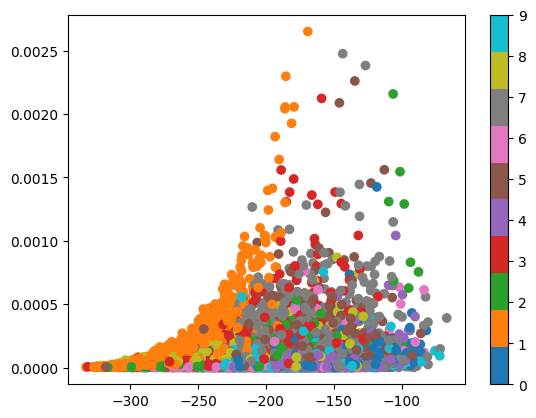

In [54]:
def plot_latent(model, data, latent=0, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = model.encoder(x)
        #print(vae.encoder.sigma.detach().numpy().shape)
        plt.scatter(model.encoder.mu.detach().numpy()[:,latent], model.encoder.sigma.detach().numpy()[:,latent], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
plot_latent(vae_test, train_loader, latent=10, num_batches=100)

By omitting the KL loss, the lattent attributes has more dispersed values. The consequence is that it is hard to sample the values of the latent attributes to generate data since it is hard to find their distributions.

## CVAE (Conditional VAE)

Random generated data has little practical usage in real life. So the goal here is to control the output by adding a condition to the decoder so the model can produce output according to the input condition. The condition is represented by an embedding of the condition.

Here, I use the simplest form of label embedding - one hot vector - to encode the label information, and then concanate to the lattent attribute. This modification affect only the decoder since the encoder doesn't rely on the label information.

In [13]:
# use the same encoder as before

class CDecoder(nn.Module):

    def __init__(self, dec_filters=[64,48,32,16,1], latent_dim=2, class_dim=10) -> None:
        
        super().__init__()
        
        self.dec_filters = dec_filters
        self.latent_dim = latent_dim
        self.class_dim = class_dim
        self.linear = nn.Linear(latent_dim + class_dim, 64*2*2)
        
        self.dec_convs = nn.Sequential()
        for i in range(len(dec_filters)-1):
            self.dec_convs.add_module(f"LayerD_conv_{i}", nn.ConvTranspose2d(dec_filters[i], dec_filters[i+1], kernel_size=2, stride=2))
            #self.dec_convs.add_module(f"LayerD_conv_{i}", nn.Upsample(scale_factor=2, mode='nearest'))
            self.dec_convs.add_module(f"LayerD_relu_{i}", nn.LeakyReLU(0.1))

        self.sigmoid = nn.Sigmoid()

    @staticmethod
    def crop(x, size=28):
        trans = transforms.CenterCrop(size)
        return trans(x)

    def forward(self, x, cls):
        cls_emb = F.one_hot(cls.long(), num_classes=self.class_dim)
        out_dec = self.linear(torch.cat((x, cls_emb), dim=1))
        out_dec = out_dec.view(-1, 64, 2, 2)
        # input size (batch, 64, 2, 2)
        out_dec = self.dec_convs(out_dec)
        
        return self.sigmoid(self.crop(out_dec))
        
        
class CVae(nn.Module):

    def __init__(self, enc_filters=[1,16,32,48,64], dec_filters=[64,48,32,16,1], latent_dim=10) -> None:
        super().__init__()
        self.encoder = Encoder(enc_filters, latent_dim)
        self.decoder = CDecoder(dec_filters,latent_dim)
        self.dec_size = dec_filters[0]


    def forward(self, x, cls):
        x = self.encoder(x)

        #out_dec = out_dec.view((x.size()[0], self.dec_size, 2, 2))

        out_dec = self.decoder(x, cls)
        
        return out_dec

cvae = CVae(latent_dim=32)
#torchsummary.summary(cvae, input_size=[(1,28,28), ()])

In [14]:
# training
import torch.optim as optim

epochs = 10
lr = 0.01

loss_fn = nn.MSELoss()
optimizer = optim.Adam(cvae.parameters(), lr=lr)


for e in range(epochs):
    loss_tot = 0
    l1_tot = 0
    l2_tot = 0
    loss_num = 0
    for data, labels in train_loader:

        pred = cvae(data, labels)
        l1, l2 = loss_func(pred, data, cvae.encoder.mu, cvae.encoder.sigma)
        
        loss = l1 + l2
        
        loss_num += len(data)
        loss_tot += loss
        l1_tot += l1
        l2_tot += l2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("epoch {}/{}: total loss: {}, reconstruction loss: {}, KL loss: {}".format(e+1, epochs, loss_tot/loss_num, l1_tot/loss_num, l2_tot/loss_num))
         

epoch 1/10: total loss: 63.967899322509766, reconstruction loss: 51.72106170654297, KL loss: 12.246797561645508
epoch 2/10: total loss: 53.79975128173828, reconstruction loss: 42.70365905761719, KL loss: 11.096125602722168
epoch 3/10: total loss: 53.51206970214844, reconstruction loss: 42.41789627075195, KL loss: 11.094170570373535
epoch 4/10: total loss: 53.419105529785156, reconstruction loss: 42.32350540161133, KL loss: 11.0955810546875
epoch 5/10: total loss: 51.06446075439453, reconstruction loss: 38.59389877319336, KL loss: 12.47055721282959
epoch 6/10: total loss: 46.18326187133789, reconstruction loss: 32.08931350708008, KL loss: 14.093954086303711
epoch 7/10: total loss: 44.948612213134766, reconstruction loss: 30.460752487182617, KL loss: 14.487836837768555
epoch 8/10: total loss: 44.04250717163086, reconstruction loss: 29.059829711914062, KL loss: 14.982670783996582
epoch 9/10: total loss: 43.202423095703125, reconstruction loss: 27.632919311523438, KL loss: 15.5695228576660

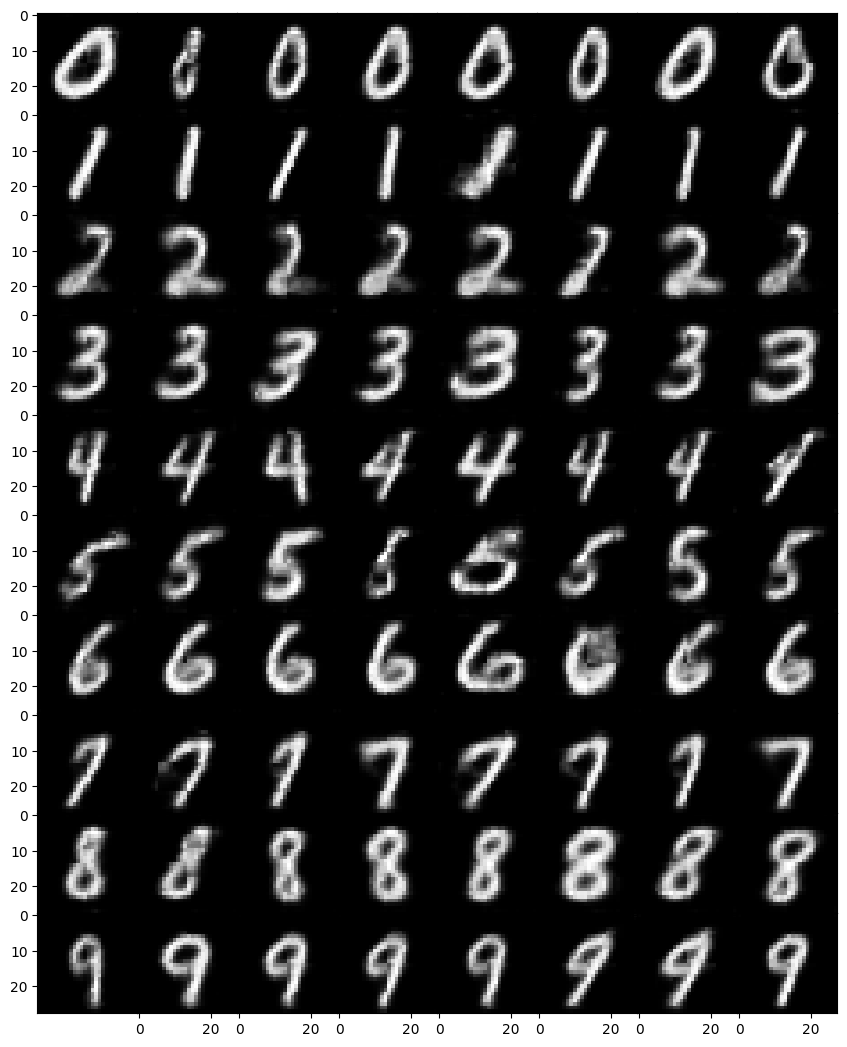

In [15]:
# valid function
normal = torch.distributions.Normal(0, 1)
def valid_test(num):
    mu = torch.rand((1,32))
    sigma = torch.rand((1,32))
    label = torch.tensor([num])
    z = cvae.encoder.sample(mu, sigma)
    #print(z.size())
    with torch.no_grad(): out = cvae.decoder(z, label)
    return out
    #plt.imshow(out[0][0], cmap="gray")

nCol = 8
nRow = 10
fig, ax = plt.subplots(nRow, nCol, gridspec_kw=dict(wspace=0.0, hspace=0.0, \
                     top=1. - 0.5 / (nRow + 1), bottom=0.5 / (nRow + 1), \
                     left=0.5 / (nCol + 1), right=1 - 0.5 / (nCol + 1)), \
                    figsize=(nCol + 1, nRow + 1),
                    sharey='row', sharex='col', #  optionally
                      )
for i in range(nRow):
    for j in range(nCol):
        im = valid_test(i)
        ax[i, j].imshow(im[0][0], cmap="gray")
        ax[i, 0].get_xaxis().set_visible(False)

For VAE, it is easy to construct the model and the training is relatively easy. In my case, as long as the learning rate is correct, the loss converges fast.
However, we hypothesis that the data follow the normal distribution. This is relative restrict hypothesis, thus the generated data lack diversity and the quality is not high. 
Moreover it is very hard to control specific feature of the generated data. There are some attempts to control the features of the data by manipulating the lattent space, but these manipulations has a lot of limitations and it is hard to generalize to all types of data.


references:
 * https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
 * https://blog.csdn.net/c9Yv2cf9I06K2A9E/article/details/129511686